# Imports

In [1]:
!pip install "tensorflow-text>=2.11";
!pip install einops;

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, TimeDistributed, Dropout, RepeatVector, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pickle
import os
import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow_text as tf_text
from collections import Counter
import string
import re
import pathlib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Data Analysis And Processing

## Load Datasets

In [3]:
data1 = pd.read_csv("/kaggle/input/arabic-to-english-translation-sentences/ara_eng.txt", delimiter="\t", names=["english", "arabic"])

In [4]:
data1

,english,arabic
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


In [5]:
data2 = pd.read_csv("/kaggle/input/arabic-to-english-sentences-dataset/ara.txt", delimiter="\t", names=['english', 'arabic', 'CC'])

In [6]:
data2.drop('CC', inplace=True, axis=1)
data2

,english,arabic
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Duck!,اخفض رأسك!
3,Duck!,اخفضي رأسك!
4,Duck!,اخفضوا رؤوسكم!
...,...,...
12408,The mobile phone you have dialed is either swi...,الهاتف المتحرك الذي طلبته مغلق أو خارج نطاق ال...
12409,If you decide to answer questions now without ...,إذا قررت الإجابة عن الأسئلة الآن دون حضور محام...
12410,A man touched down on the moon. A wall came do...,هبط إنسان على سطح القمر، وأنهار حائط في برلين،...
12411,"Ladies and gentlemen, please stand for the nat...",سيداتي و سادتي ، رجاءً قفوا للنشيد الوطني للات...


In [7]:
data = pd.concat([data1, data2], ignore_index=True)

In [8]:
data.head()

,english,arabic
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37051 entries, 0 to 37050
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  37051 non-null  object
 1   arabic   37051 non-null  object
dtypes: object(2)
memory usage: 579.0+ KB


## Handle Duplicate Data

In [10]:
num_duplicates = data.duplicated().sum()
print(f"Number of Duplicate Rows: {num_duplicates}")

Number of Duplicate Rows: 10564


In [11]:
# Remove duplicates from data
data = data.drop_duplicates()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26487 entries, 0 to 37047
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  26487 non-null  object
 1   arabic   26487 non-null  object
dtypes: object(2)
memory usage: 620.8+ KB


## Number of words per sentence

In [13]:
import plotly.subplots as sp
import plotly.graph_objects as go

input_lengths = [len(seq.split()) for seq in data['english']]
output_lengths = [len(seq.split()) for seq in data['arabic']]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('English Sentence Lengths', 'Arabic Sentence Lengths'))

hist_input = go.Histogram(x=input_lengths, nbinsx=50, name='English')
hist_output = go.Histogram(x=output_lengths, nbinsx=50, name='Arabic')

fig.add_trace(hist_input, row=1, col=1)
fig.add_trace(hist_output, row=1, col=2)

fig.update_layout(showlegend=False, title_text='Distribution of Sentence Lengths')
fig.update_xaxes(title_text='Sentence Length', row=1, col=1)
fig.update_xaxes(title_text='Sentence Length', row=1, col=2)

fig.show()

Most sentences are about 10 words

## Total Number of Unique Words in Each Language

In [14]:
import plotly.graph_objects as go

unique_words_input = len(set(word for seq in data['english'] for word in seq.split()))
unique_words_output = len(set(word for seq in data['arabic'] for word in seq.split()))

fig = go.Figure()

fig.add_trace(go.Bar(x=['English'], y=[unique_words_input], name='English'))
fig.add_trace(go.Bar(x=['Arabic'], y=[unique_words_output], name='Arabic'))

fig.update_layout(title_text='Total Number of Unique Words in Each Language', barmode='group', xaxis_title='Language', yaxis_title='Total Unique Words')

fig.show()

## Frequence of words in the language

In [15]:
# Function to remove punctuation from a sentence
def remove_punctuation(sentence):
    translator = str.maketrans("", "", string.punctuation)
    return sentence.translate(translator)

# Combine all English sentences into a single string and remove punctuation
all_english_sentences = ' '.join(data['english'])
# all_english_sentences = remove_punctuation(all_english_sentences)

# Combine all Arabic sentences into a single string and remove punctuation
all_arabic_sentences = ' '.join(data['arabic'])
# all_arabic_sentences = remove_punctuation(all_arabic_sentences)

# Count word frequencies in English sentences
english_word_counts = Counter(all_english_sentences.lower().split())

# Count word frequencies in Arabic sentences
arabic_word_counts = Counter(all_arabic_sentences.split())

target_freq = 1

# Display the number of words that occur more than 100 times for English
print(f"English Words with Frequency equals {target_freq}:")
total = 0
for word, count in english_word_counts.items():
    if count == target_freq:
        total += 1
#         print(f"{word}: {count}")
print(total)

# Display the number of words that occur more than 100 times for Arabic
print(f"Arabic Words with Frequency equals {target_freq}:")
total = 0
for word, count in arabic_word_counts.items():
    if count == target_freq:
        total += 1
#         print(f"{word}: {count}")
print(total)


English Words with Frequency equals 1:
15381
Arabic Words with Frequency equals 1:
35033


Almost half of the dataset consists of words that only appears once in the dataset. This is a huge problem becaause if one of these words appeared in the validation dataset, the model will have no idea about it. if it appeared in the training dataset, the model will never be evaluated on it.

## Number of sentences with one word

In [16]:
import plotly.express as px

# Count the number of entries with only less than 5 words for English
english_one_word_count = data['english'].apply(lambda x: 1 if len(str(x).split()) < 5 else 0).sum()

# Count the number of entries with only less than 5 words for Arabic
arabic_one_word_count = data['arabic'].apply(lambda x: 1 if len(str(x).split()) < 5 else 0).sum()

# Create a DataFrame for the plot
info = {'Language': ['English', 'Arabic'], 'Entries with less than 5 words': [english_one_word_count, arabic_one_word_count]}
df_plot = pd.DataFrame(info)

# Plot the graph using Plotly Express
fig = px.bar(df_plot, x='Language', y='Entries with less than 5 words', text='Entries with less than 5 words',
             title='Number of Entries with less than 5 words',
             labels={'Entries with less than 5 words': 'Number of Entries'})

# Show the plot
fig.show()


A lot of sentences consists of 1 word which is not a good thing for training.

In [17]:
# # Remove short sentences (< 5 words)

# # Function to count the number of words in a sentence
# def count_words(sentence):
#     return len(str(sentence).split())

# # Apply the function to each row to count words in English sentences
# data['english_word_count'] = data['english'].apply(count_words)

# # Apply the function to each row to count words in Arabic sentences
# data['arabic_word_count'] = data['arabic'].apply(count_words)

# # Filter the DataFrame to keep only records with at least 5 words in both languages
# df_filtered = data[(data['english_word_count'] >= 5) & (data['arabic_word_count'] >= 5)]

# # Drop the temporary word count columns
# data = df_filtered.drop(['english_word_count', 'arabic_word_count'], axis=1)

# # Display the filtered DataFrame
# data

Based on the above conclusions, I decided to train the model on the whole dataset which means that the validation metrics doesn't accuratly represent the preformance of the model.

# Simple Models

I started with exploring the results of simple models but I soon came to a realization that this kind of problems is nearly impossible to solve with simple model architecture that's why I didn't train the models for much longer and started exploring other architectures.

## Simple Word Tokenization

In [18]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [19]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_sequence_length = 10


# Tokenize English sentences
english_tokenizer = Tokenizer(oov_token=oov_tok,
                              lower=True)
english_tokenizer.fit_on_texts(train_df['english'])
english_vocab_size = len(english_tokenizer.word_index) + 1

# Tokenize English sentences
arabic_tokenizer = Tokenizer(oov_token=oov_tok,
                             lower=True)
arabic_tokenizer.fit_on_texts(train_df['arabic'])
arabic_vocab_size = len(arabic_tokenizer.word_index) + 1

In [20]:
# Save the tokenizers
directory = './tokenizer/'
if not os.path.exists(directory):
    os.makedirs(directory)

with open('./tokenizer/simple_english_tokenizer.pickle', 'wb+') as handle:
    pickle.dump(english_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./tokenizer/simple_arabic_tokenizer.pickle', 'wb+') as handle:
    pickle.dump(arabic_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# Convert text sequences to integer sequences
train_input_sequences = english_tokenizer.texts_to_sequences(train_df['english'])
train_output_sequences = arabic_tokenizer.texts_to_sequences(train_df['arabic'])

test_input_sequences = english_tokenizer.texts_to_sequences(test_df['english'])
test_output_sequences = arabic_tokenizer.texts_to_sequences(test_df['arabic'])


In [22]:
# Pad sequences to have the same length
train_input_sequences = pad_sequences(train_input_sequences, maxlen=max_sequence_length, padding=padding_type, truncating=trunc_type)
train_output_sequences = pad_sequences(train_output_sequences, maxlen=max_sequence_length, padding=padding_type, truncating=trunc_type)

test_input_sequences = pad_sequences(test_input_sequences, maxlen=max_sequence_length, padding=padding_type, truncating=trunc_type)
test_output_sequences = pad_sequences(test_output_sequences, maxlen=max_sequence_length, padding=padding_type, truncating=trunc_type)

### Test the tokenizers

In [23]:
english_tokenizer.sequences_to_texts(train_input_sequences[0:5])

['democracy is the worst form of government except all the',
 'history repeats itself <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>',
 'birthday presents are welcome too so if you d like',
 'on november the young leaders visitors programme of the swedish',
 'from monterrey los contratistas is a collective of street artists']

In [24]:
arabic_tokenizer.sequences_to_texts(train_output_sequences[:5])

['الديموقراطية شر أشكال الحكم، بيد أن كل الأشكال الأخرى قد',
 'التاريخ يعيد نفسه <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>',
 'وفي هذه المناسبة نستقبل الهدايا فاذا احببتم دعم عملنا نطلب',
 'في من تشرين الثاني نوفمبر استضاف برنامج القادة الشباب الزوار',
 'من مدينة مونتيري تعد مجموعة المقاولون من فناني الشارع حيث']

### Split the datasets

In [25]:
BATCH_SIZE = 256

In [26]:
is_train = np.random.uniform(size=(len(train_input_sequences),)) < 0.8

train_ds = tf.data.Dataset.from_tensor_slices((train_input_sequences[is_train], train_output_sequences[is_train])).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((train_input_sequences[~is_train], train_output_sequences[~is_train])).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_input_sequences, test_output_sequences)).batch(BATCH_SIZE)

### Define Callbacks

In [27]:
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath=f"./models/{model_name}.keras2",
                           save_weights_only=False,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True)

## LSTM Model

In [28]:
BD_LSTM = tf.keras.Sequential([
    Embedding(english_vocab_size, 256, input_length=max_sequence_length, mask_zero=True),
    Bidirectional(LSTM(256)),
    RepeatVector(max_sequence_length),
    Bidirectional(LSTM(256, return_sequences=True)),
    TimeDistributed(Dense(arabic_vocab_size, activation='softmax'))
])

In [29]:
BD_LSTM.compile(optimizer=tf.keras.optimizers.RMSprop(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [30]:
LSTM_history = BD_LSTM.fit(train_ds,
        epochs=3,
        batch_size=BATCH_SIZE,
        validation_data=validation_ds,
        callbacks=[checkpoint_callback("BD_LSTM")])

Epoch 1/3
67/67 [==============================] - 66s 800ms/step - loss: 7.4981 - accuracy: 0.3324 - val_loss: 6.2337 - val_accuracy: 0.3374
Epoch 2/3
67/67 [==============================] - 43s 645ms/step - loss: 6.0568 - accuracy: 0.3425 - val_loss: 6.1140 - val_accuracy: 0.3401
Epoch 3/3
67/67 [==============================] - 42s 640ms/step - loss: 5.9265 - accuracy: 0.3444 - val_loss: 6.0530 - val_accuracy: 0.3425


## GRU Model

In [31]:
GRU = tf.keras.Sequential([
    Embedding(english_vocab_size, 256, input_length=max_sequence_length, mask_zero=True),
    GRU(256),
    RepeatVector(max_sequence_length),
    GRU(256, return_sequences=True),
    Dense(arabic_vocab_size, activation='softmax')
])

In [32]:
GRU.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [33]:
GRU_history = GRU.fit(train_ds,
            epochs=3,
            batch_size=BATCH_SIZE,
            validation_data=validation_ds,
            callbacks=[checkpoint_callback("SIMPLE_GRU")])

Epoch 1/3
67/67 [==============================] - 39s 498ms/step - loss: 7.7124 - accuracy: 0.3297 - val_loss: 6.6222 - val_accuracy: 0.3304
Epoch 2/3
67/67 [==============================] - 10s 156ms/step - loss: 6.1405 - accuracy: 0.3354 - val_loss: 6.3918 - val_accuracy: 0.3304
Epoch 3/3
67/67 [==============================] - 21s 322ms/step - loss: 5.9748 - accuracy: 0.3381 - val_loss: 6.3797 - val_accuracy: 0.3389


## Model Evaluation

In [34]:
BD_LSTM_loss, BD_LSTM_accuracy = BD_LSTM.evaluate(test_input_sequences, test_output_sequences)
GRU_loss, GRU_accuracy = GRU.evaluate(test_input_sequences, test_output_sequences)

166/166 [==============================] - 6s 35ms/step - loss: 6.2892 - accuracy: 0.3451


In [35]:
# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'Loss': [BD_LSTM_loss, GRU_loss],
    'Accuracy': [BD_LSTM_accuracy, GRU_accuracy]
})

print(results_df)

  Model      Loss  Accuracy
0  LSTM  5.962700  0.348528
1   GRU  6.289198  0.345055


## Model inference

In [36]:
BD_LSTM = load_model('./models/BD_LSTM.keras2')
GRU = load_model('./models/SIMPLE_GRU.keras2')

In [37]:
with open('./tokenizer/simple_english_tokenizer.pickle', 'rb') as handle:
    english_tokenizer = pickle.load(handle)

with open('./tokenizer/simple_arabic_tokenizer.pickle', 'rb') as handle:
    arabic_tokenizer = pickle.load(handle)

In [38]:
def translate_sentence(sentence, model, english_tokenizer, arabic_tokenizer):
    input_sequence = english_tokenizer.texts_to_sequences([sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=model.input_shape[1], padding='post')
    predicted_sequence = model.predict(input_sequence)
    predicted_indices = np.argmax(predicted_sequence, axis=2)
    translated_sentence = arabic_tokenizer.sequences_to_texts(predicted_indices)

    return translated_sentence[0]

In [39]:
print(translate_sentence("Hello Stop", GRU, english_tokenizer, arabic_tokenizer))
print(translate_sentence("Hello jump Stop", BD_LSTM, english_tokenizer, arabic_tokenizer))

1/1 [==============================] - 1s 1s/step
<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
1/1 [==============================] - 4s 4s/step
هل توم <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>


# Attention (Using GRU) And Word Tokenization

I followed this [tutorial from the tensorflow documentation](https://www.tensorflow.org/text/tutorials/nmt_with_attention) to implement the attention mechanism.

## Word Tokenizer Using TextVectorization

In [40]:
# Load context and target sentences
def load_data(data):
  context = np.array([context for context in data["english"]])
  target = np.array([target for target in data["arabic"]])

  return target, context

In [41]:
target_raw, context_raw = load_data(data)
print(context_raw[-1])

If you decide to answer questions now without a lawyer present, you have the right to stop answering at any time.


In [42]:
print(target_raw[-1])

إذا قررت الإجابة عن الأسئلة الآن دون حضور محامي ، فيحق لك التوقف عن الإجابة في أي وقت.


In [43]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

# Train - Validation Split
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw, target_raw))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [44]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5][0].numpy().decode())
  print()
  print(example_target_strings[:5][0].numpy().decode())
  break

You have better sight than me.

أنتَ لديكَ رؤية أفضل منى؟


In [45]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-zا-ي.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [46]:
example_text = tf.constant(target_raw[-1])

print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

إذا قررت الإجابة عن الأسئلة الآن دون حضور محامي ، فيحق لك التوقف عن الإجابة في أي وقت.
[START] اذا قررت الاجابة عن الاسيلة الان دون حضور محامي  فيحق لك التوقف عن الاجابة في اي وقت . [END]


In [47]:
max_vocab_size = 60000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [48]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
print(context_text_processor.get_vocabulary()[:10])
print(context_text_processor.get_vocabulary()[-10:])
print(len(context_text_processor.get_vocabulary()))

['', '[UNK]', '[START]', '[END]', 'the', '.', 'to', 'of', 'in', 'and']
['abadi', 'abad', 'aatr', 'aasked', 'aasia', 'aamorettivp', 'aamjanata', 'aalam', 'aaboulenein', 'aaas']
26108


In [49]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
print(target_text_processor.get_vocabulary()[:10])
print(len(target_text_processor.get_vocabulary()))

['', '[UNK]', '[START]', '[END]', 'في', 'من', '.', 'على', 'ان', 'عن']
53733


In [50]:
example_tokens = context_text_processor(example_context_strings)
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] you have better sight than me . [END]'

In [51]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

## Model Architecture

In [52]:
UNITS = 1024

### Encoder

- Embedding
- Bidrectional GRUs

In [53]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

### Cross Attention
- MultiHead Attetion Layer
- Layer Normalization

In [54]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

### Decoder
- Embedding
- GRU (forward only)
- Dense

In [55]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

@Decoder.add_method
def call(self,
        context, x,
        state=None,
        return_state=False):

  # 1. Lookup the embeddings
  x = self.embedding(x)

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)

  if return_state:
    return logits, state
  else:
    return logits

@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

### Encoder-Decoder Model

In [56]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

## Define Masked Loss and Accuracy
We have to define a custom loss and accuracy to mask the padding (0)

In [57]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [58]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [59]:
model = Translator(UNITS, context_text_processor, target_text_processor)

In [60]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc])

## Model Training

In [61]:
history = model.fit(
    train_ds.repeat(),
    epochs=200,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5)
        ])

Epoch 1/200
100/100 [==============================] - 98s 823ms/step - loss: 8.7619 - masked_acc: 0.0696 - val_loss: 8.3386 - val_masked_acc: 0.0860
Epoch 2/200
100/100 [==============================] - 73s 731ms/step - loss: 8.3412 - masked_acc: 0.0996 - val_loss: 7.9893 - val_masked_acc: 0.1097
Epoch 3/200
100/100 [==============================] - 75s 748ms/step - loss: 8.0675 - masked_acc: 0.1161 - val_loss: 7.5196 - val_masked_acc: 0.1324
Epoch 4/200
100/100 [==============================] - 70s 696ms/step - loss: 7.6796 - masked_acc: 0.1446 - val_loss: 7.0387 - val_masked_acc: 0.1594
Epoch 5/200
100/100 [==============================] - 70s 703ms/step - loss: 6.9307 - masked_acc: 0.1730 - val_loss: 6.3776 - val_masked_acc: 0.2045
Epoch 6/200
100/100 [==============================] - 68s 678ms/step - loss: 6.7042 - masked_acc: 0.1935 - val_loss: 5.9680 - val_masked_acc: 0.2255
Epoch 7/200
100/100 [==============================] - 66s 663ms/step - loss: 6.5355 - masked_acc: 0

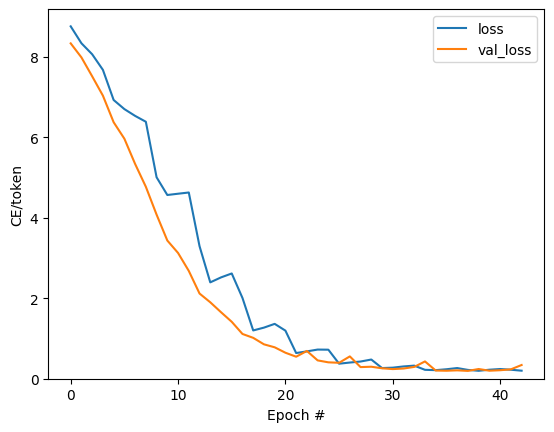

In [62]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

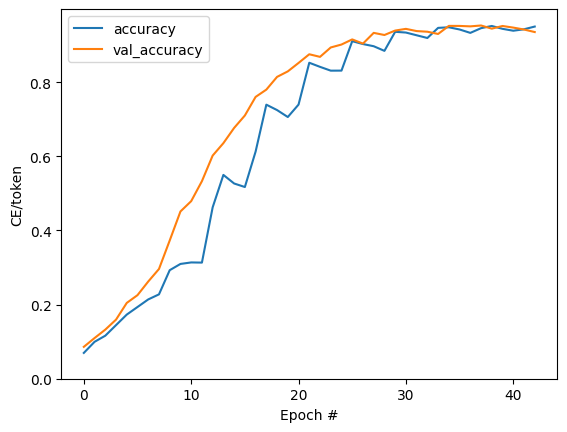

In [63]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Model Evaluation

In [64]:
result = model.translate(['How are you?']) # Are you still home
result[0].numpy().decode()

'كيف حالك '

In [65]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [66]:
export = Export(model)

In [67]:
tf.saved_model.save(export, './models/attention_wordTok',
                    signatures={'serving_default': export.translate})

In [68]:
inputs = [
    'How are you?.',
    'Where are you going?.',
    'I love red flowers'
]

In [69]:
reloaded = tf.saved_model.load('./models/attention_wordTok')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [70]:
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

كيف حالك                                                
الى اين انت ذاهب                                              
احب البنات الاحمر .                                              



The results are okayish so I started exploring other tokenization techniques like subword tokenization.

# Attention (Using GRU) And Subword Tokenization

I followed this [tutorial from the tensorflow documentation](https://www.tensorflow.org/text/guide/subwords_tokenizer) to build a subword toeknizer which in this case, I used the bert tokenizer

## Subword Tokenizer Using BertTokenizer

In [71]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_text as text

In [72]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 40000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [73]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [74]:
train_en_raw = tf.constant(train_df['english'].values)
train_ar_raw = tf.constant(train_df['arabic'].values)

In [75]:
is_train = np.random.uniform(size=(len(train_en_raw),)) < 0.8
BUFFER_SIZE = len(train_en_raw)
BATCH_SIZE = 16

# Train And Validation Split
train_ds = (tf.data.Dataset
                    .from_tensor_slices((train_en_raw, train_ar_raw)))

validation_ds = (tf.data.Dataset
                    .from_tensor_slices((train_en_raw[~is_train], train_ar_raw[~is_train])))

In [76]:
# Extract English And Arabic sentences for tokenization
train_en = train_ds.map(lambda en, ar: en)
train_ar = train_ds.map(lambda en, ar: ar)

In [77]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [78]:
# Train the tokenizers on the data
ar_vocab = bert_vocab.bert_vocab_from_dataset(
    train_ar.prefetch(tf.data.AUTOTUNE),
    **bert_vocab_args
)

en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.prefetch(tf.data.AUTOTUNE),
    **bert_vocab_args
)

In [79]:
# Save the tokenizers' vocabulary
directory = './tokenizer/subword/'
if not os.path.exists(directory):
    os.makedirs(directory)

write_vocab_file('./tokenizer/subword/ar_vocab.txt', ar_vocab)
write_vocab_file('./tokenizer/subword/en_vocab.txt', en_vocab)

### Create The Tokenizer

We have to define some methods that will be needed for training and inference

In [80]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

In [81]:
def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [82]:
tokenizers = tf.Module()
tokenizers.ar = CustomTokenizer(reserved_tokens, './tokenizer/subword/ar_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, './tokenizer/subword/en_vocab.txt')

In [83]:
model_name = './tokenizer/subword/en_ar_tokenizer'
tf.saved_model.save(tokenizers, model_name)

In [84]:
tokenizers = tf.saved_model.load(model_name)
tokenizers.en.get_vocab_size().numpy()

4878

In [85]:
tokens = tokenizers.en.tokenize(['Hello TensorFlow! ksdjfgsdjg'])
tokens.numpy()

array([[   2,   73, 2980, 4426,  488,  391, 2701,    4,   33,   57,   99,
         879,  391, 2205,   99,  879,  312,    3]])

In [86]:
text_tokens = tokenizers.en.lookup(tokens)
text_tokens

<tf.RaggedTensor [[b'[START]', b'he', b'##llo', b'tens', b'##or', b'##f', b'##low', b'!',
  b'k', b'##s', b'##d', b'##j', b'##f', b'##gs', b'##d', b'##j', b'##g',
  b'[END]']]>

In [87]:
round_trip = tokenizers.en.detokenize(tokens)

print(round_trip.numpy()[0].decode('utf-8'))

hello tensorflow ! ksdjfgsdjg


In [88]:
MAX_TOKENS=128
def prepare_batch(en, ar):
    en = tokenizers.en.tokenize(en)      # Output is ragged.
    en = en[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    en = en.to_tensor()  # Convert to 0-padded dense Tensor

    ar = tokenizers.ar.tokenize(ar)
    ar = ar[:, :(MAX_TOKENS+1)]
    ar_inputs = ar[:, :-1].to_tensor()  # Drop the [END] tokens
    ar_labels = ar[:, 1:].to_tensor()   # Drop the [START] tokens

    return (en, ar_inputs), ar_labels

In [89]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
  )

In [90]:
# Create training and validation set batches.
train_batches = make_batches(train_ds)
val_batches = make_batches(validation_ds)

In [91]:
for (en_i, ar_i), ar_o in train_batches.take(1):
    print(tokenizers.en.detokenize(en_i)[0])
    print(tokenizers.ar.detokenize(ar_i)[0].numpy().decode())    
    print(tokenizers.ar.detokenize(ar_o)[0].numpy().decode())
    print(tokenizers.en.lookup(en_i)[0])
    print(tokenizers.ar.lookup(ar_i)[0])    
    print(tokenizers.ar.lookup(ar_o)[0])

tf.Tensor(b"i don ' t care .", shape=(), dtype=string)
الامر لا يعنيني .
الامر لا يعنيني .
tf.Tensor(
[b'[START]' b'i' b'don' b"'" b't' b'care' b'.' b'[END]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]' b'[PAD]'
 b'[PAD]' b'[PAD]' b'

## Model Architecture
This model uses the same architecture as the last one

In [92]:
UNITS = 1024

In [93]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.vocab_size = text_processor.get_vocab_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)

    # 4. Returns the new sequence of embeddings.
    return x

In [94]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [95]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.vocab_size = text_processor.get_vocab_size()
    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

@Decoder.add_method
def call(self,
        context, x,
        state=None,
        return_state=False):

  # 1. Lookup the embeddings
  x = self.embedding(x)

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)

  if return_state:
    return logits, state
  else:
    return logits

In [96]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

## Define Masked Loss and Accuracy
We have to define a custom loss and accuracy to mask the padding (0)

In [97]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [98]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Model Training

In [99]:
model = Translator(UNITS, tokenizers.en, tokenizers.ar)

In [100]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc])

In [101]:
history = model.fit(
    train_batches.repeat(),
    epochs = 200,
    steps_per_epoch = 100,
    validation_data=val_batches,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)
        ]
)

Epoch 1/200
100/100 [==============================] - 48s 346ms/step - loss: 6.5865 - masked_acc: 0.1049 - val_loss: 5.7588 - val_masked_acc: 0.1490
Epoch 2/200
100/100 [==============================] - 29s 291ms/step - loss: 5.7473 - masked_acc: 0.1518 - val_loss: 5.0162 - val_masked_acc: 0.1969
Epoch 3/200
100/100 [==============================] - 27s 270ms/step - loss: 5.3996 - masked_acc: 0.1713 - val_loss: 4.5472 - val_masked_acc: 0.2305
Epoch 4/200
100/100 [==============================] - 25s 252ms/step - loss: 4.6792 - masked_acc: 0.2164 - val_loss: 4.1288 - val_masked_acc: 0.2665
Epoch 5/200
100/100 [==============================] - 25s 246ms/step - loss: 4.4225 - masked_acc: 0.2314 - val_loss: 3.8415 - val_masked_acc: 0.2943
Epoch 6/200
100/100 [==============================] - 23s 231ms/step - loss: 4.4284 - masked_acc: 0.2349 - val_loss: 3.4455 - val_masked_acc: 0.3318
Epoch 7/200
100/100 [==============================] - 23s 228ms/step - loss: 4.0104 - masked_acc: 0

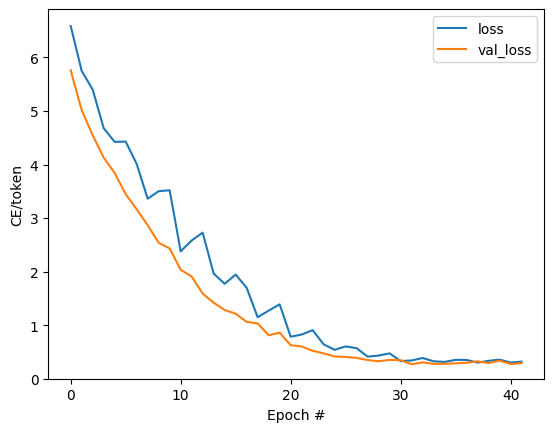

In [102]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

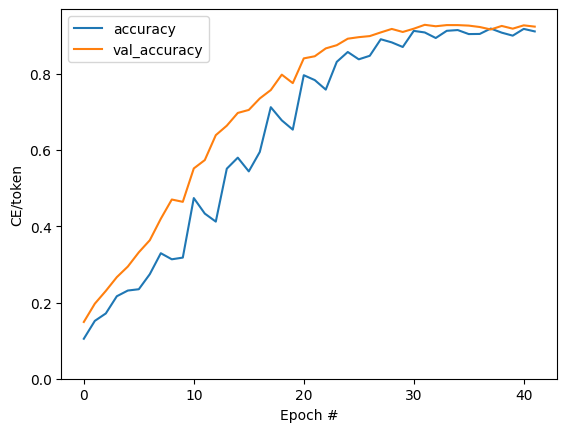

In [103]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Model Evaluation

I created a wrapper for the model and implemented the inference logic

In [104]:
class TranslatorWrapper(tf.Module):
  def __init__(self, tokenizers, model):
    self.tokenizers = tokenizers
    self.model = model

  def __call__(self, sentence, max_length=128):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.en.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.ar.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.model([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.ar.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.ar.lookup(output)[0]

    return text, tokens

In [105]:
translator = TranslatorWrapper(tokenizers, model)

In [106]:
sentence = 'Hello'

translated_text, translated_tokens = translator(
    tf.constant(sentence))

print(sentence, translated_text.numpy().decode('utf-8'), sep='\n')

Hello
مرحبا .


In [107]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [108]:
translator = ExportTranslator(translator)

In [109]:
tf.saved_model.save(translator, export_dir='./models/attention_gru_subword')

In [110]:
reloaded = tf.saved_model.load('./models/attention_gru_subword')
reloaded('I love cats').numpy().decode('utf-8')

'انا احب القطط الغذايية الكلية'

# Transformer (4-Layers) And Subword Tokenization

I followed this [tutorial from the tensorflow documentation](https://www.tensorflow.org/text/tutorials/transformer) to implement the Transformer architecture.

This model uses the subword tokenizer defined for the previous model

## Model Architecture

In [111]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


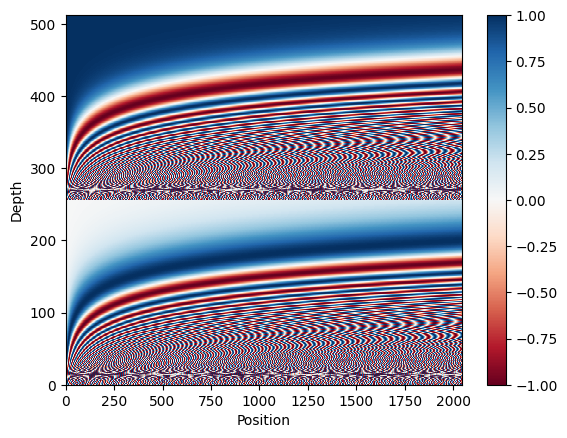

In [112]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

### Positional Embedding

In [113]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Attention Layers

In [114]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [115]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [116]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [117]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### FeedForward Neural Netword

In [118]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

### Encoder Unit

In [119]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

### Encoder Model

The encoder model uses one or more encoder units

In [120]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

### Decoder Unit

In [121]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

### Decoder Model

The decoder model uses one or more decoder units

In [122]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

### Transformer Model

In [123]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Model Training

In [124]:
num_layers = 4 # 6
d_model = 128 # 512
dff = 512 # 2048
num_heads = 8
dropout_rate = 0.1

In [125]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.ar.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [126]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [127]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [128]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [129]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [130]:
history = transformer.fit(train_batches,
                epochs=200,
                validation_data=val_batches,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(patience=10)
                    ])

Epoch 1/200
332/332 [==============================] - 171s 413ms/step - loss: 8.2498 - masked_accuracy: 0.0391 - val_loss: 7.4085 - val_masked_accuracy: 0.0521
Epoch 2/200
332/332 [==============================] - 97s 292ms/step - loss: 7.0647 - masked_accuracy: 0.0733 - val_loss: 6.7020 - val_masked_accuracy: 0.0992
Epoch 3/200
332/332 [==============================] - 87s 262ms/step - loss: 6.4717 - masked_accuracy: 0.1077 - val_loss: 6.1875 - val_masked_accuracy: 0.1217
Epoch 4/200
332/332 [==============================] - 83s 249ms/step - loss: 6.0895 - masked_accuracy: 0.1293 - val_loss: 5.8121 - val_masked_accuracy: 0.1465
Epoch 5/200
332/332 [==============================] - 80s 241ms/step - loss: 5.7549 - masked_accuracy: 0.1507 - val_loss: 5.4324 - val_masked_accuracy: 0.1731
Epoch 6/200
332/332 [==============================] - 79s 239ms/step - loss: 5.4364 - masked_accuracy: 0.1704 - val_loss: 5.0602 - val_masked_accuracy: 0.1998
Epoch 7/200
332/332 [==================

In [131]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  3263232   
                                                                 
 decoder_2 (Decoder)         multiple                  5631232   
                                                                 
 dense_20 (Dense)            multiple                  888294    
                                                                 
Total params: 9782758 (37.32 MB)
Trainable params: 9782758 (37.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model Evaluation

I have used the wrapper defined for the previous model

In [132]:
translator = TranslatorWrapper(tokenizers, transformer)

In [133]:
sentence = 'Hello'

translated_text, translated_tokens = translator(
    tf.constant(sentence))

print(sentence, translated_text.numpy().decode('utf-8'), sep='\n')

Hello
مرحبا .


In [134]:
sentence = 'How are you?'

translated_text, translated_tokens = translator(
    tf.constant(sentence))

print(sentence, translated_text.numpy().decode('utf-8'), sep='\n')

How are you?
كيف حالك ؟


In [135]:
translator = ExportTranslator(translator)

In [136]:
tf.saved_model.save(translator, export_dir='./models/translator_with_transformers')

In [137]:
reloaded = tf.saved_model.load('./models/translator_with_transformers')
reloaded('I love cats').numpy().decode('utf-8')

'انا احب القطط .'

# Using Pre-Trained Model From HuggingFace API

Finally, I wanted to try pretrained models so I used the `marefa-mt-en-ar` from the hugging face API

In [138]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("translation_en_to_ar", model="marefa-nlp/marefa-mt-en-ar")

# Translate text
text = "Hello my friends! How are you doing today?"
output = pipe(text)

print(output)


config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/917k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning:

Recommended: pip install sacremoses.



[{'translation_text': 'هالو ياأصدقائي كيف تبلين اليوم؟'}]


In [139]:
text = "Machine Learning sucks"

output = pipe(text)

print(output)

[{'translation_text': 'تمتص التعلم الآلي'}]


In [140]:
text = """Why did the programmer hate machine learning? It kept predicting their failed relationships with uncanny accuracy."""

output = pipe(text)

print(output)

[{'translation_text': 'لماذا تعلم المبرمج كاره الآلة؟ لقد ظل يتنبأ بعلاقاتهم الفاشلة بدقة غير قابلة للتقنية.'}]
